<a href="https://colab.research.google.com/github/rafz1/CLSTM-SEGTHOR/blob/main/CLSTM_SegTHOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SegTHOR video frame segmentation using Convolutional LSTM networks

* Unidirectional Convolutional LSTM networks (UConvLSTM)
* Bidirectional Convlutional LSTM networks (BConvLSTM)
* ConvLSTM extension with encoder-decoder (BUnetConvLSTM)

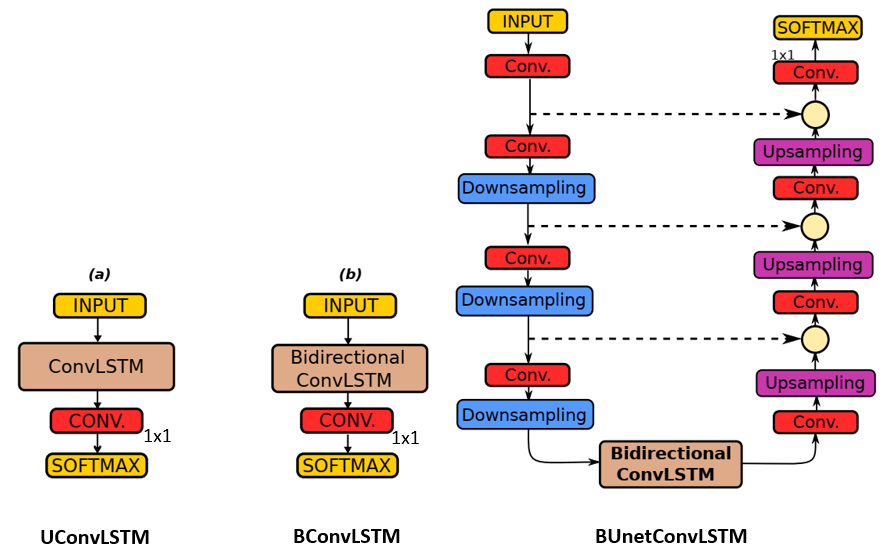

## Install packages and import libraries

In [ ]:
%tensorflow_version 2.8
!pip install icecream
!pip install keras==2.6


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.6.0 which is incompatible.


In [ ]:
import cv2
import os
import glob
import numpy as np
import pdb
from pathlib import Path
import csv
import threading
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose, ConvLSTM2D, Activation, BatchNormalization, Bidirectional, TimeDistributed, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


import sys
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16
from icecream import ic
import time

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

## Mount drive and clone the repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
t0 = time.time()

Mounted at /content/drive


## Create Dataset



In [ ]:
!unzip drive/My\ Drive/SegTHOR/images.zip -d /content/dataset > /dev/null
!unzip drive/My\ Drive/SegTHOR/test.zip -d /content/dataset > /dev/null
!unzip drive/My\ Drive/SegTHOR/labels.zip -d /content/dataset > /dev/null

In [ ]:
!mkdir /content/input/

!mkdir /content/input/segmentation
!mkdir /content/input/segmentation/test
!mkdir /content/input/segmentation/train
!mkdir /content/input/segmentation/train/augmentation
!mkdir /content/input/segmentation/train/image
!mkdir /content/input/segmentation/train/mask
!mkdir /content/input/segmentation/train/dilate

In [ ]:
!mkdir /content/data_0/
!mkdir /content/data_1/
!mkdir /content/data_2/
!mkdir /content/data_3/
!mkdir /content/data_4/
!mkdir /content/label_0/
!mkdir /content/label_1/
!mkdir /content/label_2/
!mkdir /content/label_3/
!mkdir /content/label_4/

In [ ]:
!mkdir /content/dataset/train_lstm
!mkdir /content/dataset/train_lstm/img
!mkdir /content/dataset/train_lstm/img/patients
!mkdir /content/dataset/train_lstm/img/patients/0
!mkdir /content/dataset/train_lstm/img/patients/1
!mkdir /content/dataset/train_lstm/img/patients/2
!mkdir /content/dataset/train_lstm/img/patients/3
!mkdir /content/dataset/train_lstm/img/patients/4
!mkdir /content/dataset/train_lstm/label
!mkdir /content/dataset/train_lstm/label/0
!mkdir /content/dataset/train_lstm/label/1
!mkdir /content/dataset/train_lstm/label/2
!mkdir /content/dataset/train_lstm/label/3
!mkdir /content/dataset/train_lstm/label/4

!mkdir /content/dataset/test_lstm
!mkdir /content/dataset/test_lstm/img
!mkdir /content/dataset/test_lstm/label
!mkdir /content/dataset/test_lstm/img/patients
!mkdir /content/dataset/test_lstm/img/patients/0
!mkdir /content/dataset/test_lstm/img/patients/1
!mkdir /content/dataset/test_lstm/img/patients/2
!mkdir /content/dataset/test_lstm/img/patients/3
!mkdir /content/dataset/test_lstm/img/patients/4
!mkdir /content/dataset/test_lstm/label/0
!mkdir /content/dataset/test_lstm/label/1
!mkdir /content/dataset/test_lstm/label/2
!mkdir /content/dataset/test_lstm/label/3
!mkdir /content/dataset/test_lstm/label/4

In [ ]:
DATASET_DIR = os.path.join("dataset")

SEGTHOR_TEST_DIR = os.path.join(DATASET_DIR, "test")
SEGTHOR_TRAIN_DIR = os.path.join(DATASET_DIR, "images")
SEGTHOR_TRAIN_label_DIR = os.path.join(DATASET_DIR, "labels")

SEGTHOR_TRAIN_LSTM = os.path.join(DATASET_DIR, "train_lstm")
SEGTHOR_TRAIN_LSTM_IMG = os.path.join(SEGTHOR_TRAIN_LSTM, "img")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS = os.path.join(SEGTHOR_TRAIN_LSTM_IMG, "patients")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0 = os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS, "0")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1 = os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS, "1")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2 = os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS, "2")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3 = os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS, "3")
SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4 = os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS, "4")
SEGTHOR_TRAIN_LSTM_LABEL = os.path.join(SEGTHOR_TRAIN_LSTM, "label")
SEGTHOR_TRAIN_LSTM_LABEL_0 = os.path.join(SEGTHOR_TRAIN_LSTM_LABEL, "0")
SEGTHOR_TRAIN_LSTM_LABEL_1 = os.path.join(SEGTHOR_TRAIN_LSTM_LABEL, "1")
SEGTHOR_TRAIN_LSTM_LABEL_2 = os.path.join(SEGTHOR_TRAIN_LSTM_LABEL, "2")
SEGTHOR_TRAIN_LSTM_LABEL_3 = os.path.join(SEGTHOR_TRAIN_LSTM_LABEL, "3")
SEGTHOR_TRAIN_LSTM_LABEL_4 = os.path.join(SEGTHOR_TRAIN_LSTM_LABEL, "4")

SEGTHOR_TEST_LSTM = os.path.join(DATASET_DIR, "test_lstm")
SEGTHOR_TEST_LSTM_IMG = os.path.join(SEGTHOR_TEST_LSTM, "img")
SEGTHOR_TEST_LSTM_IMG_PATIENTS = os.path.join(SEGTHOR_TEST_LSTM_IMG, "patients")
SEGTHOR_TEST_LSTM_IMG_PATIENTS_0 = os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS, "0")
SEGTHOR_TEST_LSTM_IMG_PATIENTS_1 = os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS, "1")
SEGTHOR_TEST_LSTM_IMG_PATIENTS_2 = os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS, "2")
SEGTHOR_TEST_LSTM_IMG_PATIENTS_3 = os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS, "3")
SEGTHOR_TEST_LSTM_IMG_PATIENTS_4 = os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS, "4")
SEGTHOR_TEST_LSTM_LABEL = os.path.join(SEGTHOR_TEST_LSTM, "label")
SEGTHOR_TEST_LSTM_LABEL_0 = os.path.join(SEGTHOR_TEST_LSTM_LABEL, "0")
SEGTHOR_TEST_LSTM_LABEL_1 = os.path.join(SEGTHOR_TEST_LSTM_LABEL, "1")
SEGTHOR_TEST_LSTM_LABEL_2 = os.path.join(SEGTHOR_TEST_LSTM_LABEL, "2")
SEGTHOR_TEST_LSTM_LABEL_3 = os.path.join(SEGTHOR_TEST_LSTM_LABEL, "3")
SEGTHOR_TEST_LSTM_LABEL_4 = os.path.join(SEGTHOR_TEST_LSTM_LABEL, "4")

INPUT_DIR = os.path.join("input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")


DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
#EPOCHS=56

#Desv
EPOCHS=10

APAGAR ARQUIVOS NULOS

In [ ]:
train_img = glob(os.path.join(SEGTHOR_TRAIN_DIR, '*.png'))
test_img = glob(os.path.join(SEGTHOR_TEST_DIR, '*.png'))
label_img = glob(os.path.join(SEGTHOR_TRAIN_label_DIR, '*.png'))

for img in train_img:
  image = cv2.imread(img, 0)
  #gray_version = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  if cv2.countNonZero(image) == 0:
    os.remove(img)

for img in test_img:
  image = cv2.imread(img, 0)
  #gray_version = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  if cv2.countNonZero(image) == 0:
    os.remove(img)

for img in label_img:
  image = cv2.imread(img, 0)
  #gray_version = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  if cv2.countNonZero(image) == 0:
    os.remove(img)


In [ ]:
segthor_train_mask = glob(os.path.join(SEGTHOR_TRAIN_label_DIR, '*label.png'))
segthor_train_img = glob(os.path.join(SEGTHOR_TRAIN_DIR, '*.png'))

segthor_test_mask = glob(os.path.join(SEGTHOR_TEST_DIR, '*label.png'))
segthor_test_img = glob(os.path.join(SEGTHOR_TEST_DIR, '*image.png'))

##### ORDENA OS PACIENTES
segthor_train_mask = np.sort(segthor_train_mask)
segthor_train_img = np.sort(segthor_train_img)

segthor_test_mask = np.sort(segthor_test_mask)
segthor_test_img = np.sort(segthor_test_img)


for mask_file in tqdm(segthor_train_mask):
    base_file = os.path.basename(mask_file).replace("_label", "_image")
    image_file = os.path.join(SEGTHOR_TRAIN_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, 0)
    image_gray = cv2.imread(image_file, 0)
    
    ###### CROP    
    image = image[104:408, 104:408]
    mask = mask[104:408, 104:408]
    image_gray = image_gray[104:408, 104:408]
    ##########
    resize_img = cv2.resize(image_gray, (64,64), interpolation = cv2.INTER_NEAREST) 
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    mask_1 = np.array(mask)
    mask_2 = np.array(mask)
    mask_3 = np.array(mask)
    mask_4 = np.array(mask)
    
    mask_1[mask_1 != 1] = 0
    mask_1 = cv2.resize(mask_1, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask_2[mask_2 != 2] = 0
    mask_2[mask_2 != 0] = 1
    mask_2 = cv2.resize(mask_2, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask_3[mask_3 != 3] = 0
    mask_3[mask_3 != 0] = 1
    mask_3 = cv2.resize(mask_3, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask_4[mask_4 != 4] = 0
    mask_4[mask_4 != 0] = 1
    mask_4 = cv2.resize(mask_4, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask[mask != 0] = 1

    resize_mask_0 = cv2.resize(mask, (64,64), interpolation = cv2.INTER_NEAREST) 
      
    if len(mask_1[mask_1 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, base_file), \
                  mask_1)
    if len(mask_2[mask_2 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, base_file), \
          resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, base_file), \
                  mask_2)
    if len(mask_3[mask_3 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, base_file), \
          resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, base_file), \
                  mask_3)
    if len(mask_4[mask_4 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, base_file), \
          resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, base_file), \
                  mask_4)
    if len(mask[mask == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, base_file), \
          resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, base_file), \
                  resize_mask_0)
            

for mask_file_test in tqdm(segthor_test_mask):
    base_file = os.path.basename(mask_file_test).replace("label", "image")
    image_file = os.path.join(SEGTHOR_TEST_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file_test, 0)
    image_gray = cv2.imread(image_file, 0)
    
    ###### CROP    
    image = image[104:408, 104:408]
    mask = mask[104:408, 104:408]
    image_gray = image_gray[104:408, 104:408]
    ##########

    resize_img = cv2.resize(image_gray, (64,64), interpolation = cv2.INTER_NEAREST) 
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    mask_1 = np.array(mask)
    mask_2 = np.array(mask)
    mask_3 = np.array(mask)
    mask_4 = np.array(mask)

    mask_1[mask_1 != 1] = 0
    mask_1 = cv2.resize(mask_1, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask_2[mask_2 != 2] = 0
    mask_2[mask_2 != 0] = 1
    mask_2 = cv2.resize(mask_2, (64,64), interpolation = cv2.INTER_NEAREST) 
    
    mask_3[mask_3 != 3] = 0
    mask_3[mask_3 != 0] = 1
    mask_3 = cv2.resize(mask_3, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask_4[mask_4 != 4] = 0
    mask_4[mask_4 != 0] = 1
    mask_4 = cv2.resize(mask_4, (64,64), interpolation = cv2.INTER_NEAREST) 

    mask[mask != 0] = 1

    resize_mask_0 = cv2.resize(mask, (64,64), interpolation = cv2.INTER_NEAREST) 
    

    if len(mask_1[mask_1 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_1, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_LABEL_1, base_file), \
                  mask_1)
    if len(mask_2[mask_2 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_2, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_LABEL_2, base_file), \
                  mask_2)
    if len(mask_3[mask_3 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_3, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_LABEL_3, base_file), \
                  mask_3)
    if len(mask_4[mask_4 == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_4, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_LABEL_4, base_file), \
                  mask_4)
    if len(mask[mask == 1]) > 0:
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_0, base_file), \
                resize_img)
      cv2.imwrite(os.path.join(SEGTHOR_TEST_LSTM_LABEL_0, base_file), \
                  resize_mask_0)
      

100%|██████████| 2281/2281 [00:23<00:00, 97.40it/s]


IGUALA O NÚMERO DE IMAGENS

In [ ]:
initial_count_0 = 0
num_max_0 = 0
num_min_0 = 0

initial_count_1 = 0
num_max_1 = 0
num_min_1 = 0

initial_count_2 = 0
num_max_2 = 0
num_min_2 = 0

initial_count_3 = 0
num_max_3 = 0
num_min_3 = 0

initial_count_4 = 0
num_max_4 = 0
num_min_4 = 0

initial_count_label_0 = 0
num_max_label_0 = 0
num_min_label_0 = 0

initial_count_label_1 = 0
num_max_label_1 = 0
num_min_label_1 = 0

initial_count_label_2 = 0
num_max_label_2 = 0
num_min_label_2 = 0

initial_count_label_3 = 0
num_max_label_3 = 0
num_min_label_3 = 0

initial_count_label_4 = 0
num_max_label_4 = 0
num_min_label_4 = 0

for i in range(1, 41):
  if i < 10:
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_0' + str(i) + '*')):
      initial_count_0 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_0' + str(i) + '*')):
      initial_count_1 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_0' + str(i) + '*')):
      initial_count_2 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_0' + str(i) + '*')):
      initial_count_3 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_0' + str(i) + '*')):
      initial_count_4 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_0' + str(i) + '*')):
      initial_count_label_0 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_0' + str(i) + '*')):
      initial_count_label_1 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_0' + str(i) + '*')):
      initial_count_label_2 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_0' + str(i) + '*')):
      initial_count_label_3 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_0' + str(i) + '*')):
      initial_count_label_4 += 1
  else:
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
      initial_count_0 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
      initial_count_1 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
      initial_count_2 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
      initial_count_3 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
      initial_count_4 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
      initial_count_label_0 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
      initial_count_label_1 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
      initial_count_label_2 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
      initial_count_label_3 += 1
    for path in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
      initial_count_label_4 += 1

  if initial_count_0 > num_max_0:
    num_max_0 = initial_count_0
  if initial_count_1 > num_max_1:
    num_max_1 = initial_count_1
  if initial_count_2 > num_max_2:
    num_max_2 = initial_count_2
  if initial_count_3 > num_max_3:
    num_max_3 = initial_count_3
  if initial_count_4 > num_max_4:
    num_max_4 = initial_count_4
  
  if i == 1 or (num_min_0 > initial_count_0 and 1 < i < 41):
    num_min_0 = initial_count_0
  if i == 1 or (num_min_1 > initial_count_1 and 1 < i < 41):
    num_min_1 = initial_count_1
  if i == 1 or (num_min_2 > initial_count_2 and 1 < i < 41):
    num_min_2 = initial_count_2
  if i == 1 or (num_min_3 > initial_count_3 and 1 < i < 41):
    num_min_3 = initial_count_3
  if i == 1 or (num_min_4 > initial_count_4 and 1 < i < 41):
    num_min_4 = initial_count_4
  if i == 1 or (num_min_label_0 > initial_count_label_0 and 1 < i < 41):
    num_min_label_0 = initial_count_label_0
  if i == 1 or (num_min_label_1 > initial_count_label_1 and 1 < i < 41):
    num_min_label_1 = initial_count_label_1
  if i == 1 or (num_min_label_2 > initial_count_label_2 and 1 < i < 41):
    num_min_label_2 = initial_count_label_2
  if i == 1 or (num_min_label_3 > initial_count_label_3 and 1 < i < 41):
    num_min_label_3 = initial_count_label_3
  if i == 1 or (num_min_label_4 > initial_count_label_4 and 1 < i < 41):
    num_min_label_4 = initial_count_label_4

  if initial_count_label_0 > num_max_label_0:
    num_max_label_0 = initial_count_label_0
  if initial_count_label_1 > num_max_label_1:
    num_max_label_1 = initial_count_label_1
  if initial_count_label_2 > num_max_label_2:
    num_max_label_2 = initial_count_label_2
  if initial_count_label_3 > num_max_label_3:
    num_max_label_3 = initial_count_label_3
  if initial_count_label_4 > num_max_label_4:
    num_max_label_4 = initial_count_label_4

  #print("paciente " + str(i) + ": " + str(initial_count) + "arquivos")
  initial_count_0 = 0
  initial_count_1 = 0
  initial_count_2 = 0
  initial_count_3 = 0
  initial_count_4 = 0
  initial_count_label_0 = 0
  initial_count_label_1 = 0
  initial_count_label_2 = 0
  initial_count_label_3 = 0
  initial_count_label_4 = 0

print("Número máximo de imagens: " + str(num_max_0))
print("Número mínimo de imagens: " + str(num_min_0))
print("Número máximo de imagens 1: " + str(num_max_1))
print("Número mínimo de imagens 1: " + str(num_min_1))
print("Número máximo de imagens 2: " + str(num_max_2))
print("Número mínimo de imagens 2: " + str(num_min_2))
print("Número máximo de imagens 3: " + str(num_max_3))
print("Número mínimo de imagens 3: " + str(num_min_3))
print("Número máximo de imagens 4: " + str(num_max_4))
print("Número mínimo de imagens 4: " + str(num_min_4))
print("Número máximo de labels: " + str(num_max_label_0))
print("Número mínimo de labels: " + str(num_min_label_0))
print("Número máximo de labels 1: " + str(num_max_label_1))
print("Número mínimo de labels 1: " + str(num_min_label_1))
print("Número máximo de labels 2: " + str(num_max_label_2))
print("Número mínimo de labels 2: " + str(num_min_label_2))
print("Número máximo de labels 3: " + str(num_max_label_3))
print("Número mínimo de labels 3: " + str(num_min_label_3))
print("Número máximo de labels 4: " + str(num_max_label_4))
print("Número mínimo de labels 4: " + str(num_min_label_4))

Número máximo de imagens: 142
Número mínimo de imagens: 96
Número máximo de imagens 1: 136
Número mínimo de imagens 1: 79
Número máximo de imagens 2: 62
Número mínimo de imagens 2: 27
Número máximo de imagens 3: 65
Número mínimo de imagens 3: 35
Número máximo de imagens 4: 116
Número mínimo de imagens 4: 78
Número máximo de labels: 142
Número mínimo de labels: 96
Número máximo de labels 1: 136
Número mínimo de labels 1: 79
Número máximo de labels 2: 62
Número mínimo de labels 2: 27
Número máximo de labels 3: 65
Número mínimo de labels 3: 35
Número máximo de labels 4: 116
Número mínimo de labels 4: 78


In [ ]:
initial_count_test_0 = 0
num_max_test_0 = 0
num_min_test_0 = 0

initial_count_test_1 = 0
num_max_test_1 = 0
num_min_test_1 = 0

initial_count_test_2 = 0
num_max_test_2 = 0
num_min_test_2 = 0

initial_count_test_3 = 0
num_max_test_3 = 0
num_min_test_3 = 0

initial_count_test_4 = 0
num_max_test_4 = 0
num_min_test_4 = 0

initial_count_label_test_0 = 0
num_max_label_test_0 = 0
num_min_label_test_0 = 0

initial_count_label_test_1 = 0
num_max_label_test_1 = 0
num_min_label_test_1 = 0

initial_count_label_test_2 = 0
num_max_label_test_2 = 0
num_min_label_test_2 = 0

initial_count_label_test_3 = 0
num_max_label_test_3 = 0
num_min_label_test_3 = 0

initial_count_label_test_4 = 0
num_max_label_test_4 = 0
num_min_label_test_4 = 0

for i in range(41, 61):
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
    initial_count_test_0 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
    initial_count_test_1 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
    initial_count_test_2 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
    initial_count_test_3 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
    initial_count_test_4 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
    initial_count_label_test_0 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
    initial_count_label_test_1 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
    initial_count_label_test_2 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
    initial_count_label_test_3 += 1
  for path in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
    initial_count_label_test_4 += 1
  
  if initial_count_test_0 > num_max_test_0:
    num_max_test_0 = initial_count_test_0
  if initial_count_test_1 > num_max_test_1:
    num_max_test_1 = initial_count_test_1
  if initial_count_test_2 > num_max_test_2:
    num_max_test_2 = initial_count_test_2
  if initial_count_test_3 > num_max_test_3:
    num_max_test_3 = initial_count_test_3
  if initial_count_test_4 > num_max_test_4:
    num_max_test_4 = initial_count_test_4
  
  if i == 41 or (num_min_test_0 > initial_count_test_0 and 41 < i < 61):
    num_min_test_0 = initial_count_test_0
  if i == 41 or (num_min_test_1 > initial_count_test_1 and 41 < i < 61):
    num_min_test_1 = initial_count_test_1
  if i == 41 or (num_min_test_2 > initial_count_test_2 and 41 < i < 61):
    num_min_test_2 = initial_count_test_2
  if i == 41 or (num_min_test_3 > initial_count_test_3 and 41 < i < 61):
    num_min_test_3 = initial_count_test_3
  if i == 41 or (num_min_test_4 > initial_count_test_4 and 41 < i < 61):
    num_min_test_4 = initial_count_test_4
  
  if i == 41 or (num_min_label_test_0 > initial_count_label_test_0 and 41 < i < 61):
    num_min_label_test_0 = initial_count_label_test_0
  if i == 41 or (num_min_label_test_1 > initial_count_label_test_1 and 41 < i < 61):
    num_min_label_test_1 = initial_count_label_test_1
  if i == 41 or (num_min_label_test_2 > initial_count_label_test_2 and 41 < i < 61):
    num_min_label_test_2 = initial_count_label_test_2
  if i == 41 or (num_min_label_test_3 > initial_count_label_test_3 and 41 < i < 61):
    num_min_label_test_3 = initial_count_label_test_3
  if i == 41 or (num_min_label_test_4 > initial_count_label_test_4 and 41 < i < 61):
    num_min_label_test_4 = initial_count_label_test_4

  if initial_count_label_test_0 > num_max_label_test_0:
    num_max_label_test_0 = initial_count_label_test_0
  if initial_count_label_test_1 > num_max_label_test_1:
    num_max_label_test_1 = initial_count_label_test_1
  if initial_count_label_test_2 > num_max_label_test_2:
    num_max_label_test_2 = initial_count_label_test_2
  if initial_count_label_test_3 > num_max_label_test_3:
    num_max_label_test_3 = initial_count_label_test_3
  if initial_count_label_test_4 > num_max_label_test_4:
    num_max_label_test_4 = initial_count_label_test_4

  #print("paciente " + str(i) + ": " + str(initial_count) + "arquivos")
  initial_count_test_0 = 0
  initial_count_test_1 = 0
  initial_count_test_2 = 0
  initial_count_test_3 = 0
  initial_count_test_4 = 0
  initial_count_label_test_0 = 0
  initial_count_label_test_1 = 0
  initial_count_label_test_2 = 0
  initial_count_label_test_3 = 0
  initial_count_label_test_4 = 0

print("Número máximo de imagens: " + str(num_max_test_0))
print("Número mínimo de imagens: " + str(num_min_test_0))
print("Número máximo de imagens 1: " + str(num_max_test_1))
print("Número mínimo de imagens 1: " + str(num_min_test_1))
print("Número máximo de imagens 2: " + str(num_max_test_2))
print("Número mínimo de imagens 2: " + str(num_min_test_2))
print("Número máximo de imagens 3: " + str(num_max_test_3))
print("Número mínimo de imagens 3: " + str(num_min_test_3))
print("Número máximo de imagens 4: " + str(num_max_test_4))
print("Número mínimo de imagens 4: " + str(num_min_test_4))
print("Número máximo de labels: " + str(num_max_label_test_0))
print("Número mínimo de labels: " + str(num_min_label_test_0))
print("Número máximo de labels 1: " + str(num_max_label_test_1))
print("Número mínimo de labels 1: " + str(num_min_label_test_1))
print("Número máximo de labels 2: " + str(num_max_label_test_2))
print("Número mínimo de labels 2: " + str(num_min_label_test_2))
print("Número máximo de labels 3: " + str(num_max_label_test_3))
print("Número mínimo de labels 3: " + str(num_min_label_test_3))
print("Número máximo de labels 4: " + str(num_max_label_test_4))
print("Número mínimo de labels 4: " + str(num_min_label_test_4))

Número máximo de imagens: 143
Número mínimo de imagens: 88
Número máximo de imagens 1: 117
Número mínimo de imagens 1: 72
Número máximo de imagens 2: 47
Número mínimo de imagens 2: 28
Número máximo de imagens 3: 61
Número mínimo de imagens 3: 35
Número máximo de imagens 4: 116
Número mínimo de imagens 4: 67
Número máximo de labels: 143
Número mínimo de labels: 88
Número máximo de labels 1: 117
Número mínimo de labels 1: 72
Número máximo de labels 2: 47
Número mínimo de labels 2: 28
Número máximo de labels 3: 61
Número mínimo de labels 3: 35
Número máximo de labels 4: 116
Número mínimo de labels 4: 67


In [ ]:
if num_min_test_0 < num_min_0:
  num_min_0 = num_min_test_0
if num_min_test_1 < num_min_1:
  num_min_1 = num_min_test_1
if num_min_test_2 < num_min_2:
  num_min_2 = num_min_test_2
if num_min_test_3 < num_min_3:
  num_min_3 = num_min_test_3
if num_min_test_4 < num_min_4:
  num_min_4 = num_min_test_4
if num_min_label_test_0 < num_min_label_0:
  num_min_label_0 = num_min_label_test_0
if num_min_label_test_1 < num_min_label_1:
  num_min_label_1 = num_min_label_test_1
if num_min_label_test_2 < num_min_label_2:
  num_min_label_2 = num_min_label_test_2
if num_min_label_test_3 < num_min_label_3:
  num_min_label_3 = num_min_label_test_3
if num_min_label_test_4 < num_min_label_4:
  num_min_label_4 = num_min_label_test_4

In [ ]:
num_min_2

27

APAGA IMAGENS POR LABEL

In [ ]:
num_files = 0
num_objetivo = num_min_0
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_1
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_2
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_3
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_4
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

APAGA LABEL 0

In [ ]:
num_files = 0
num_objetivo = num_min_label_0
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_label_0
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_0, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

APAGA LABEL 1

In [ ]:
num_files = 0
num_objetivo = num_min_label_1
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = 88
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_1, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

APAGA LABEL 2

In [ ]:
num_files = 0
num_objetivo = num_min_label_2
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_label_2
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_2, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

APAGA LABEL 3

In [ ]:
num_files = 0
num_objetivo = num_min_label_3
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_label_3
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_3, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

APAGA LABEL 4

In [ ]:
num_files = 0
num_objetivo = num_min_label_4
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(1, 41):
  if i < 10:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_0' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_0' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0
  else:
    num_files = len([f for f in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_' + str(i) + '*'))]) 
    if num_files > num_objetivo:
      quantidade_excedente = num_files - num_objetivo 
      razao = num_objetivo // quantidade_excedente
      for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
        if quantidade_excedente == 0:
          break
        elif count_razao == razao and num_files > num_objetivo:
          count_razao = 0
          os.remove(arquivo)
          quantidade_excedente -= 1
          #!rm $arquivo
        else:
          count_razao += 1
      num_files = 0
      quantidade_excedente = 0
      razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_label_4
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_4, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

APAGA IMAGENS BASE TESTE POR LABEL

In [ ]:
num_files = 0
num_objetivo = num_min_0
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_1
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_2
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_3
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

In [ ]:
num_files = 0
num_objetivo = num_min_4
razao = 0
count_razao = 0
quantidade_excedente = 0

for i in range(41, 61):
  num_files = len([f for f in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*'))]) 
  if num_files > num_objetivo:
    quantidade_excedente = num_files - num_objetivo 
    razao = num_objetivo // quantidade_excedente
    for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
      if quantidade_excedente == 0:
        break
      elif count_razao == razao and num_files > num_objetivo:
        count_razao = 0
        os.remove(arquivo)
        quantidade_excedente -= 1
        #!rm $arquivo
      else:
        count_razao += 1
    num_files = 0
    quantidade_excedente = 0
    razao = 0

CRIA ARRAY COM AS IMAGENS E LABELS

In [ ]:
video_image_array_0 = []
video_image_array_1 = []
video_image_array_2 = []
video_image_array_3 = []
video_image_array_4 = []
video_label_array_0 = []
video_label_array_1 = []
video_label_array_2 = []
video_label_array_3 = []
video_label_array_4 = []

for i in range(1, 41):
  if i < 10:
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_0.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_1.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_2.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_3.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_4.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_0.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_1.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_2.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_3.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_0' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_4.append(arquivo)
  else:
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_0.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_1.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_2.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_3.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      video_image_array_4.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_0.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_1.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_2.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_3.append(arquivo)
    for arquivo in glob(os.path.join(SEGTHOR_TRAIN_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
      arquivo = cv2.imread(arquivo)
      arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
      arquivo = np.repeat(arquivo, 2, axis=-1)
      arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
      video_label_array_4.append(arquivo)

In [ ]:
video_image_array_0 = np.array(video_image_array_0)
video_image_array_1 = np.array(video_image_array_1)
video_image_array_2 = np.array(video_image_array_2)
video_image_array_3 = np.array(video_image_array_3)
video_image_array_4 = np.array(video_image_array_4)
video_label_array_0 = np.array(video_label_array_0)
video_label_array_1 = np.array(video_label_array_1)
video_label_array_2 = np.array(video_label_array_2)
video_label_array_3 = np.array(video_label_array_3)
video_label_array_4 = np.array(video_label_array_4)
print(video_image_array_0.shape)
print(video_image_array_1.shape)
print(video_image_array_2.shape)
print(video_image_array_3.shape)
print(video_image_array_4.shape)
print(video_label_array_0.shape)
print(video_label_array_1.shape)
print(video_label_array_2.shape)
print(video_label_array_3.shape)
print(video_label_array_4.shape)

(3520, 64, 64, 3)
(2880, 64, 64, 3)
(1080, 64, 64, 3)
(1400, 64, 64, 3)
(2680, 64, 64, 3)
(3520, 64, 64, 2)
(2880, 64, 64, 2)
(1080, 64, 64, 2)
(1400, 64, 64, 2)
(2680, 64, 64, 2)


In [ ]:
video_image_array_test_0 = []
video_image_array_test_1 = []
video_image_array_test_2 = []
video_image_array_test_3 = []
video_image_array_test_4 = []
video_label_array_test_0 = []
video_label_array_test_1 = []
video_label_array_test_2 = []
video_label_array_test_3 = []
video_label_array_test_4 = []

for i in range(41, 61):
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_0, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    video_image_array_test_0.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_1, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    video_image_array_test_1.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_2, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    video_image_array_test_2.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_3, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    video_image_array_test_3.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_IMG_PATIENTS_4, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    video_image_array_test_4.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_0, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
    arquivo = np.repeat(arquivo, 2, axis=-1)
    arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
    video_label_array_test_0.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_1, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
    arquivo = np.repeat(arquivo, 2, axis=-1)
    arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
    video_label_array_test_1.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_2, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
    arquivo = np.repeat(arquivo, 2, axis=-1)
    arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
    video_label_array_test_2.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_3, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
    arquivo = np.repeat(arquivo, 2, axis=-1)
    arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
    video_label_array_test_3.append(arquivo)
  for arquivo in glob(os.path.join(SEGTHOR_TEST_LSTM_LABEL_4, 'Patient_' + str(i) + '*')):
    arquivo = cv2.imread(arquivo)
    arquivo = np.expand_dims(arquivo[:, :, 0], axis = 2)
    arquivo = np.repeat(arquivo, 2, axis=-1)
    arquivo[:, :, 0] = arquivo[:, :, 0] ^ 1
    video_label_array_test_4.append(arquivo)

In [ ]:
video_image_array_test_0 = np.array(video_image_array_test_0)
video_image_array_test_1 = np.array(video_image_array_test_1)
video_image_array_test_2 = np.array(video_image_array_test_2)
video_image_array_test_3 = np.array(video_image_array_test_3)
video_image_array_test_4 = np.array(video_image_array_test_4)
video_label_array_test_0 = np.array(video_label_array_test_0)
video_label_array_test_1 = np.array(video_label_array_test_1)
video_label_array_test_2 = np.array(video_label_array_test_2)
video_label_array_test_3 = np.array(video_label_array_test_3)
video_label_array_test_4 = np.array(video_label_array_test_4)
print(video_image_array_test_0.shape)
print(video_image_array_test_1.shape)
print(video_image_array_test_2.shape)
print(video_image_array_test_3.shape)
print(video_image_array_test_4.shape)
print(video_label_array_test_0.shape)
print(video_label_array_test_1.shape)
print(video_label_array_test_2.shape)
print(video_label_array_test_3.shape)
print(video_label_array_test_4.shape)

(1760, 64, 64, 3)
(1440, 64, 64, 3)
(540, 64, 64, 3)
(700, 64, 64, 3)
(1340, 64, 64, 3)
(1760, 64, 64, 2)
(1733, 64, 64, 2)
(540, 64, 64, 2)
(700, 64, 64, 2)
(1340, 64, 64, 2)


In [ ]:
aux_0 = 0
aux_1 = 0
aux_2 = 0
aux_3 = 0
aux_4 = 0
valor_0 = num_min_0
valor_1 = num_min_1
valor_2 = num_min_2
valor_3 = num_min_3
valor_4 = num_min_4

for i in range (1, 41):
  np.save('/content/data_0/patient_' + str(i) + '.npy', video_image_array_0[aux_0:valor_0])
  np.save('/content/label_0/patient_' + str(i) + '.npy', video_label_array_0[aux_0:valor_0])
  np.save('/content/data_1/patient_' + str(i) + '.npy', video_image_array_1[aux_1:valor_1])
  np.save('/content/label_1/patient_' + str(i) + '.npy', video_label_array_1[aux_1:valor_1])
  np.save('/content/data_2/patient_' + str(i) + '.npy', video_image_array_2[aux_2:valor_2])
  np.save('/content/label_2/patient_' + str(i) + '.npy', video_label_array_2[aux_2:valor_2])
  np.save('/content/data_3/patient_' + str(i) + '.npy', video_image_array_3[aux_3:valor_3])
  np.save('/content/label_3/patient_' + str(i) + '.npy', video_label_array_3[aux_3:valor_3])
  np.save('/content/data_4/patient_' + str(i) + '.npy', video_image_array_4[aux_4:valor_4])
  np.save('/content/label_4/patient_' + str(i) + '.npy', video_label_array_4[aux_4:valor_4])

  aux_0 = valor_0
  valor_0 += num_min_0
  aux_1 = valor_1
  valor_1 += num_min_1
  aux_2 = valor_2
  valor_2 += num_min_2
  aux_3 = valor_3
  valor_3 += num_min_3
  aux_4 = valor_4
  valor_4 += num_min_4

In [ ]:
aux_0 = 0
aux_1 = 0
aux_2 = 0
aux_3 = 0
aux_4 = 0
valor_0 = num_min_0
valor_1 = num_min_1
valor_2 = num_min_2
valor_3 = num_min_3
valor_4 = num_min_4

for i in range (41, 61):
  np.save('/content/data_0/patient_' + str(i) + '.npy', video_image_array_test_0[aux_0:valor_0])
  np.save('/content/label_0/patient_' + str(i) + '.npy', video_label_array_test_0[aux_0:valor_0])
  np.save('/content/data_1/patient_' + str(i) + '.npy', video_image_array_test_1[aux_1:valor_1])
  np.save('/content/label_1/patient_' + str(i) + '.npy', video_label_array_test_1[aux_1:valor_1])
  np.save('/content/data_2/patient_' + str(i) + '.npy', video_image_array_test_2[aux_2:valor_2])
  np.save('/content/label_2/patient_' + str(i) + '.npy', video_label_array_test_2[aux_2:valor_2])
  np.save('/content/data_3/patient_' + str(i) + '.npy', video_image_array_test_3[aux_3:valor_3])
  np.save('/content/label_3/patient_' + str(i) + '.npy', video_label_array_test_3[aux_3:valor_3])
  np.save('/content/data_4/patient_' + str(i) + '.npy', video_image_array_test_4[aux_4:valor_4])
  np.save('/content/label_4/patient_' + str(i) + '.npy', video_label_array_test_4[aux_4:valor_4])

  aux_0 = valor_0
  valor_0 += num_min_0
  aux_1 = valor_1
  valor_1 += num_min_1
  aux_2 = valor_2
  valor_2 += num_min_2
  aux_3 = valor_3
  valor_3 += num_min_3
  aux_4 = valor_4
  valor_4 += num_min_4

In [ ]:
a = np.load('/content/label_1/patient_1.npy')

In [ ]:
print(np.unique(a[20, :, :, :]))

[0 1]


In [ ]:
print(a[20, :, :, :])

[[[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]

 ...

 [[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [1 0]
  ...
  [1 0]
  [1 0]
  [1 0]]]


In [ ]:
cv2.imwrite("/content/drive/MyDrive/class_4_background.jpg", \
                  a[17, :, :, 0]*255)

True

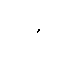

In [ ]:
cv2_imshow(a[17, :, :, 0]*255)

In [ ]:
cv2.imwrite("/content/drive/MyDrive/class_4_foreground.jpg", \
                  a[17, :, :, 1]*255)

True

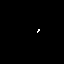

In [ ]:
cv2_imshow(a[17, :, :, 1]*255)

## Specify parameters



In [ ]:
##---------------- Parameters --------------------------##
im_len=64 # Input image length
t_len_0 = num_min_0 
t_len_1 = num_min_1 
t_len_2 = num_min_2 
t_len_3 = num_min_3 
t_len_4 = num_min_4 
batch_size = 1

params_0 = {
    'dim': (t_len_0,im_len,im_len),
    'Nto1_label_dim': (im_len,im_len),
    'batch_size': batch_size, 
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': False,   
    'class_number': 0}

params_1 = {
    'dim': (t_len_1,im_len,im_len),
    'Nto1_label_dim': (im_len,im_len),
    'batch_size': batch_size, 
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': False,
    'class_number': 1}

params_2 = {
    'dim': (t_len_2,im_len,im_len),
    'Nto1_label_dim': (im_len,im_len),
    'batch_size': batch_size, 
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': False,
    'class_number': 2}

params_3 = {
    'dim': (t_len_3,im_len,im_len),
    'Nto1_label_dim': (im_len,im_len),
    'batch_size': batch_size, 
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': False,
    'class_number': 3}

params_4 = {
    'dim': (t_len_4,im_len,im_len),
    'Nto1_label_dim': (im_len,im_len),
    'batch_size': batch_size, 
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': False,
    'class_number': 4}


paramsTest_0 = params_0.copy()
paramsTest_0['batch_size']=1
paramsTest_0['shuffle']=False

paramsTest_1 = params_1.copy()
paramsTest_1['batch_size']=1
paramsTest_1['shuffle']=False

paramsTest_2 = params_2.copy()
paramsTest_2['batch_size']=1
paramsTest_2['shuffle']=False

paramsTest_3 = params_3.copy()
paramsTest_3['batch_size']=1
paramsTest_3['shuffle']=False

paramsTest_4 = params_4.copy()
paramsTest_4['batch_size']=1
paramsTest_4['shuffle']=False

dtype = np.float32
class_weights = np.array([0.54248901, 6.38387407]).astype(np.float16) 
#class_weights = np.array([1, 1]).astype(np.float16) 


## Data generator class

The DataGenerator class loads each train / validation / test batch separately, for efficient memory usage (See https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly for more on data generators)

In [ ]:
class DataGenerator(tensorflow.keras.utils.Sequence):
	'Generates data for Keras'
	def __init__(self, list_IDs, labels, class_number, batch_size=1, dim=(88,64,64), Nto1_label_dim=(64,64), n_channels=3,
				 n_classes=1, shuffle=False):
		'Initialization'
		self.dim = dim
		self.batch_size = batch_size
		self.labels = labels
		self.list_IDs = list_IDs
		print("self.list_IDs",self.list_IDs)
		self.n_channels = n_channels
		self.n_classes = n_classes
		self.shuffle = shuffle
		self.class_number = class_number
		self.Nto1_label_dim = Nto1_label_dim
		self.on_epoch_end()

	def __len__(self):
		'Denotes the number of batches per epoch'
		return int(np.floor(len(self.list_IDs) / self.batch_size))

	def __getitem__(self, index):
		'Generate one batch of data'
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs[k] for k in indexes]

		# Generate data
		X, y = self.__data_generation(list_IDs_temp)

		return X, y

	def on_epoch_end(self):
		'Updates indexes after each epoch'
		self.indexes = np.arange(len(self.list_IDs))
		if self.shuffle == True:
			np.random.shuffle(self.indexes)

	def scalerApply(self, X):
		X_shape = X.shape
		X = np.reshape(X, (-1, X_shape[-1]))
		X = self.scaler.transform(X)
		X = np.reshape(X, X_shape)
		return X

	def __data_generation(self, list_IDs_temp):
		'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
		# Initialization
		X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=dtype)

		Y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=dtype)
		
    # Generate data
		for i, ID in enumerate(list_IDs_temp):
			# Store sample

			X[i,] = np.load('/content/data_' + str(self.class_number) + '/patient_' + ID + '.npy').astype(dtype)/255.0
			
			Y[i] = np.load('/content/label_' + str(self.class_number) + '/patient_' + ID + '.npy').astype(dtype)

		return X, Y



## Define train/test split

In [ ]:
def partition_get():
	partition={}

	partition['train'] = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
	                      '11','12', '13', '14', '15', '16', '17', '18', '19','20',
												'21','22', '23', '24', '25', '26', '27', '28', '29','30',
												'31','32']

	ic(partition['train'])

	partition['validation'] = ['33', '34', '35', '36', '37', '38', '39','40']

	ic(partition['validation'])
 
	partition['test'] = ['41', '42', '43', '44', '45', '46', '47','48', '49', '50',
	                     '51', '52', '53', '54', '55', '56', '57','58', '59', '60']
	ic(partition['test'])

	return partition

In [ ]:
partition = partition_get()
training_generator_0 = DataGenerator(partition['train'], partition['train'], **params_0)
validation_generator_0 = DataGenerator(partition['validation'], partition['validation'], **params_0)
test_generator_0 = DataGenerator(partition['test'], partition['test'], **paramsTest_0)

training_generator_1 = DataGenerator(partition['train'], partition['train'], **params_1)
validation_generator_1 = DataGenerator(partition['validation'], partition['validation'], **params_1)
test_generator_1 = DataGenerator(partition['test'], partition['test'], **paramsTest_1)

training_generator_2 = DataGenerator(partition['train'], partition['train'], **params_2)
validation_generator_2 = DataGenerator(partition['validation'], partition['validation'], **params_2)
test_generator_2 = DataGenerator(partition['test'], partition['test'], **paramsTest_2)

training_generator_3 = DataGenerator(partition['train'], partition['train'], **params_3)
validation_generator_3 = DataGenerator(partition['validation'], partition['validation'], **params_3)
test_generator_3 = DataGenerator(partition['test'], partition['test'], **paramsTest_3)

training_generator_4 = DataGenerator(partition['train'], partition['train'], **params_4)
validation_generator_4 = DataGenerator(partition['validation'], partition['validation'], **params_4)
test_generator_4 = DataGenerator(partition['test'], partition['test'], **paramsTest_4)


ic| partition['train']: ['1',
                         '2',
                         '3',
                         '4',
                         '5',
                         '6',
                         '7',
                         '8',
                         '9',
                         '10',
                         '11',
                         '12',
                         '13',
                         '14',
                         '15',
                         '16',
                         '17',
                         '18',
                         '19',
                         '20',
                         '21',
                         '22',
                         '23',
                         '24',
                         '25',
                         '26',
                         '27',
                         '28',
                         '29',
                         '30',
                         '31',
                         '32']
ic| partition['va

self.list_IDs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
self.list_IDs ['33', '34', '35', '36', '37', '38', '39', '40']
self.list_IDs ['41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
self.list_IDs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
self.list_IDs ['33', '34', '35', '36', '37', '38', '39', '40']
self.list_IDs ['41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
self.list_IDs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
self.list_

## Define the model

* Unidirectional ConvLSTM (UConvLSTM): It consists of a unidirectional ConvLSTM followed by a convolutional layer with 1x1 kernel size and softmax activation function. Notice that this is a fully convolutional architecture. The input is a sequence of images, and the outcome is the semantic segmentation of the last element in the sequence (Hint: Use the keras ConvLSTM layer. To configure it as N-to-1, see its return_sequences parameter). 
* Bidirectional ConvLSTM (BConvLSTM): The same architecture as in step 1, but the ConvLSTM is configured as bidirectional. Hint: Use the Bidirectional() wrapper in keras. This architecture is shown in the next figure (b)
* BUnetConvLSTM: First, a Unet-like encoder is applied to each frame in the temporal sequence (Hint: Use the TimeDistributed() wrapper). Then, the resulting sequence of feature representations is passed to a bidirectional ConvLSTM (Hint: The ConvLSTM returns only the last element in the sequence). The resulting representation is then passed to a Unet-like decoder which recovers the input spatial dimensions. The student is not required to use skip connections. 

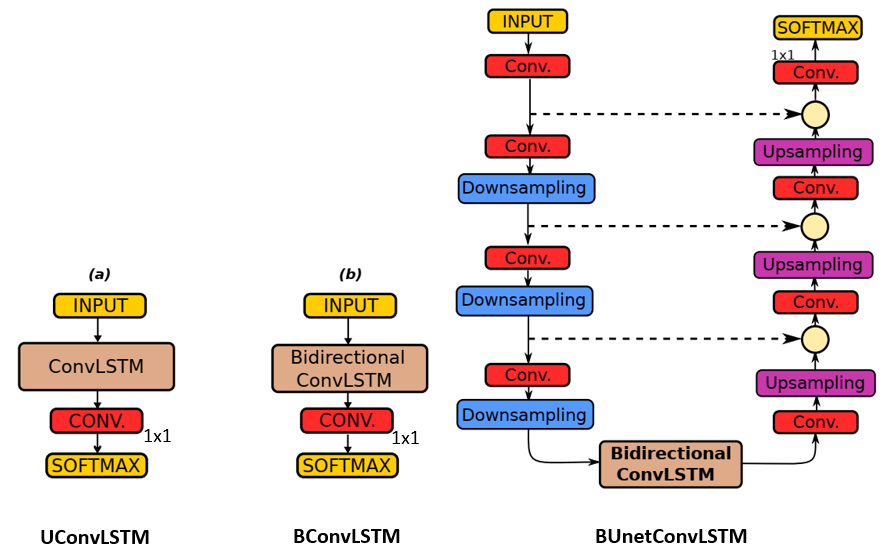

In [ ]:

def convolution_layer_over_time(x,filter_size,dilation_rate=1, kernel_size=3, weight_decay=1E-4):
	x = TimeDistributed(Conv2D(filter_size, kernel_size, padding='same'))(x)
	x = BatchNormalization(gamma_regularizer=l2(weight_decay),
						beta_regularizer=l2(weight_decay))(x)
	x = Activation('relu')(x)
	return x
def convolution_layer(x,filter_size,dilation_rate=1, kernel_size=3, weight_decay=1E-4):
	x = Conv2D(filter_size, kernel_size, padding='same')(x)
	x = BatchNormalization(gamma_regularizer=l2(weight_decay),
						beta_regularizer=l2(weight_decay))(x)
	x = Activation('relu')(x)
	return x
def transpose_layer(x,filter_size,dilation_rate=1, 
	kernel_size=3, strides=(2,2), weight_decay=1E-4):
	x = Conv2DTranspose(filter_size, 
		kernel_size, strides=strides, padding='same')(x)
	x = BatchNormalization(gamma_regularizer=l2(weight_decay),
										beta_regularizer=l2(weight_decay))(x)
	x = Activation('relu')(x)
	return x	
def transpose_layer_over_time(x,filter_size,dilation_rate=1, 
	kernel_size=3, strides=(2,2), weight_decay=1E-4):
	x = TimeDistributed(Conv2DTranspose(filter_size, 
		kernel_size, strides=strides, padding='same'))(x)
	x = BatchNormalization(gamma_regularizer=l2(weight_decay),
										beta_regularizer=l2(weight_decay))(x)
	x = Activation('relu')(x)
	return x	

In [ ]:

# Input shape (N_samples, t_len, h, w, channels) 
def UConvLSTM_NtoN(params):
	in_im = Input(shape=(*params['dim'], params['n_channels']))
	weight_decay=1E-4
	x = ConvLSTM2D(60,3,return_sequences=True,
			padding="same")(in_im)
	out = TimeDistributed(Conv2D(params['n_classes'], (1, 1), activation='softmax',
								padding='same'))(x)
	model = Model(in_im, out)
	print(model.summary())
	return model
  
def BConvLSTM_NtoN(params):
	in_im = Input(shape=(*params['dim'], params['n_channels']))
	weight_decay=1E-4
	x = Bidirectional(ConvLSTM2D(60,3,return_sequences=True,
			padding="same"),merge_mode='concat')(in_im)
	out = TimeDistributed(Conv2D(params['n_classes'], (1, 1), activation='softmax',
								padding='same'))(x)
	model = Model(in_im, out)
	print(model.summary())
	return model
  
def BUnetConvLSTM_NtoN(params):
	in_im = Input(shape=(*params['dim'], params['n_channels']))
  # Your model here
	weight_decay=1E-4

	fs=16
	p1=convolution_layer_over_time(in_im,fs)			
	p1=convolution_layer_over_time(p1,fs)
	e1 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p1)
	p2=convolution_layer_over_time(e1,fs*2)
	e2 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p2)
	p3=convolution_layer_over_time(e2,fs*4)
	e3 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p3)

	x = Bidirectional(ConvLSTM2D(60,3,return_sequences=True,
			padding="same"),merge_mode='concat')(e3)

	d3 = transpose_layer_over_time(x,fs*4)
	d3 = tensorflow.keras.layers.concatenate([d3, p3], axis=-1)
	d3=convolution_layer_over_time(d3,fs*4)
	d2 = transpose_layer_over_time(d3,fs*2)
	d2 = tensorflow.keras.layers.concatenate([d2, p2], axis=-1)
	d2=convolution_layer_over_time(d2,fs*2)
	d1 = transpose_layer_over_time(d2,fs)
	d1 = tensorflow.keras.layers.concatenate([d1, p1], axis=-1)
	out=convolution_layer_over_time(d1,fs)
	out = TimeDistributed(Conv2D(params['n_classes'], (1, 1), activation='softmax',
								padding='same'))(out)
	model = Model(in_im, out)
	print(model.summary())

	return model

def UUnetConvLSTM_NtoN(params):
	in_im = Input(shape=(*params['dim'], params['n_channels']))
  # Your model here
	weight_decay=1E-4

	fs=16
	p1=convolution_layer_over_time(in_im,fs)			
	p1=convolution_layer_over_time(p1,fs)
	e1 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p1)
	p2=convolution_layer_over_time(e1,fs*2)
	e2 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p2)
	p3=convolution_layer_over_time(e2,fs*4)
	e3 = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(p3)

	x = ConvLSTM2D(60,3,return_sequences=True,
			padding="same")(e3)

	d3 = transpose_layer_over_time(x,fs*4)
	d3 = keras.layers.concatenate([d3, p3], axis=-1)
	d3=convolution_layer_over_time(d3,fs*4)
	d2 = transpose_layer_over_time(d3,fs*2)
	d2 = keras.layers.concatenate([d2, p2], axis=-1)
	d2=convolution_layer_over_time(d2,fs*2)
	d1 = transpose_layer_over_time(d2,fs)
	d1 = keras.layers.concatenate([d1, p1], axis=-1)
	out=convolution_layer_over_time(d1,fs)
	out = TimeDistributed(Conv2D(params['n_classes'], (1, 1), activation='softmax',
								padding='same'))(out)
	model = Model(in_im, out)
	print(model.summary())

	return model



In [ ]:
t0 = time.time()


In [ ]:
!nvidia-smi

Fri Nov 11 16:08:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# model = BConvLSTM_NtoN(params)
# model = UConvLSTM_NtoN(params)
# model = UUnetConvLSTM_NtoN(params)
#model = BUnetConvLSTM_NtoN(params)

models = {}
# models['0'] = [BUnetConvLSTM_NtoN(params_0), training_generator_0, test_generator_0, validation_generator_0, params_0]
models['1'] = [BUnetConvLSTM_NtoN(params_1), training_generator_1, test_generator_1, validation_generator_1, params_1]
# models['2'] = [BUnetConvLSTM_NtoN(params_2), training_generator_2, test_generator_2, validation_generator_2, params_2]
# models['3'] = [BUnetConvLSTM_NtoN(params_3), training_generator_3, test_generator_3, validation_generator_3, params_3]
# models['4'] = [BUnetConvLSTM_NtoN(params_4), training_generator_4, test_generator_4, validation_generator_4, params_4]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 64, 64,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 72, 64, 64, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 72, 64, 64, 1 64          time_distributed[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 72, 64, 64, 1 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Define the weighted categorical cross-entropy

In [ ]:

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

print(class_weights)

[0.5425 6.383 ]


## Train the model

In [ ]:
from sklearn import metrics
def load_labels(partition, params):
	samples = np.zeros((len(partition), *params['dim'] , params['n_classes']))
	for idx, filename in enumerate(partition):
		ic(filename)
		samples[idx] = np.load('label_' + str(params['class_number']) + '/patient_' + filename +'.npy')
	return samples

In [ ]:
!pip install imageio
!pip install -q git+https://github.com/tensorflow/docs
import imageio
from tensorflow_docs.vis import embed

def to_gif(images, id):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./model'+ str(id) + '.gif', converted_images, fps=4)
  return embed.embed_file('./model'+ str(id) + '.gif')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def presentResultsAsGif(ID, params):
  X = np.load('data_' + str(params['class_number']) + '/patient_' + ID + '.npy').astype(dtype)/255.0
  Y = np.load('label_' + str(params['class_number']) + '/patient_' + ID + '.npy').astype(dtype)

  Y = Y.argmax(axis = -1)

  #print(X.shape, Y.shape)

  prediction_probability = model.predict(np.expand_dims(X, axis = 0))
  prediction_probability = np.squeeze(prediction_probability)

  prediction = prediction_probability.argmax(axis = -1)
  prediction_probability = prediction_probability[...,1]
  
  print(Y.shape)

  reference_to_show = np.repeat(np.expand_dims(Y, axis=-1), 3, axis=-1)
  prediction_to_show = np.repeat(np.expand_dims(prediction, axis=-1), 3, axis=-1)
  prediction_probability_to_show = np.repeat(np.expand_dims(prediction_probability, axis=-1), 3, axis=-1)
  
  # print(prediction_probability_to_show.shape)
  print(reference_to_show.shape)
  # print(prediction_to_show.shape)
  # print(X.shape)
  return np.concatenate((X, reference_to_show, prediction_probability_to_show, prediction_to_show), axis=2)


In [ ]:
for name in models:
  print('#########################')
  print(f'Training {name}')

  model = models[name][0]
  optimizer = Adam(learning_rate = 1e-3 , beta_1=0.9)

  model.compile(optimizer = optimizer,
      loss=weighted_categorical_crossentropy(class_weights),
      metrics=['accuracy'])
  
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
  history = model.fit(models[name][1], validation_data=models[name][3],
          epochs=1000,
          callbacks = [es])

  predictions = model.predict_generator(models[name][3])

  labels = load_labels(partition['validation'], models[name][4])

  # get metrics
  labels_flat = labels.argmax(axis=-1).flatten()
  predictions_flat = predictions.argmax(axis=-1).flatten()
  report = classification_report(labels_flat,predictions_flat)

  print(report)
  print(confusion_matrix(labels_flat,predictions_flat))
  model.save("/content/drive/MyDrive/model_200_" + str(name) + ".h5", save_format='h5')


  ic(np.unique(predictions, return_counts=True))
  ic(np.unique(predictions_flat, return_counts=True))

  ID = '30'
  to_gif(presentResultsAsGif(ID, models[name][4]), name)
  embed.embed_file("./model"+ str(name) + ".gif")

In [ ]:
from tensorflow.keras import models
model = models.load_model('/content/drive/MyDrive/model4.h5', compile=False)

optimizer = Adam(learning_rate = 1e-3 , beta_1=0.9)

model.compile(optimizer = optimizer,
    loss=weighted_categorical_crossentropy(class_weights),
    metrics=['accuracy'])

## Test the model

In [ ]:
from sklearn import metrics
def load_labels(partition, params):
	samples = np.zeros((len(partition), *params['dim'] , params['n_classes']))
	for idx, filename in enumerate(partition):
		ic(filename)
		samples[idx] = np.load('label_' + str(params['class_number']) + '/patient_' + filename +'.npy')
	return samples
  
#predictions = model.predict_generator(validation_generator_1)

predictions = model.predict_generator(test_generator_1)

labels = load_labels(partition['test'], paramsTest_1)

#labels = load_labels(partition['validation'], params_1)

# get metrics
labels_flat = labels.argmax(axis=-1).flatten()
predictions_flat = predictions.argmax(axis=-1).flatten()
report = classification_report(labels_flat,predictions_flat)

print(report)
print(confusion_matrix(labels_flat,predictions_flat))

ic(np.unique(predictions, return_counts=True))
ic(np.unique(predictions_flat, return_counts=True))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
ic| filename: '41'
ic| filename: '42'
ic| filename: '43'
ic| filename: '44'
ic| filename: '45'
ic| filename: '46'
ic| filename: '47'
ic| filename: '48'
ic| filename: '49'
ic| filename: '50'
ic| filename: '51'
ic| filename: '52'
ic| filename: '53'
ic| filename: '54'
ic| filename: '55'
ic| filename: '56'
ic| filename: '57'
ic| filename: '58'
ic| filename: '59'
ic| filename: '60'


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5885038
           1       0.08      0.06      0.07     13202

    accuracy                           1.00   5898240
   macro avg       0.54      0.53      0.53   5898240
weighted avg       1.00      1.00      1.00   5898240

[[5876018    9020]
 [  12398     804]]


ic| np.unique(predictions, return_counts=True): (array([1.3575004e-05, 1.5683863e-05, 1.6192138e-05, ..., 9.9998379e-01,
                                                       9.9998426e-01, 9.9998641e-01], dtype=float32),
                                                 array([1, 1, 1, ..., 1, 1, 1]))
ic| np.unique(predictions_flat, return_counts=True): (array([0, 1]), array([5888416,    9824]))


(array([0, 1]), array([5888416,    9824]))

## Visual results of the semantic segmentation

In [ ]:
# You: Produce visual results of the semantic segmentation
print(time.time() - t0)

In [ ]:
!pip install imageio
!pip install -q git+https://github.com/tensorflow/docs
import imageio
from tensorflow_docs.vis import embed

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=4)
  return embed.embed_file('./animation.gif')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def dice_coef(y_true, y_pred):
    dice = []
    for i in range(y_true.shape[0]):
      y_true_f = tf.reshape(tf.dtypes.cast(y_true[i, :, :, :], tf.float32), [-1])
      y_pred_f = tf.reshape(tf.dtypes.cast(y_pred[i, :, :, :], tf.float32), [-1])
      intersection = tf.reduce_sum(y_true_f * y_pred_f)
      dice.append((2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.))

    return sum(dice)/len(dice)

In [ ]:
def presentResultsAsGif(ID):
  X = np.load('data_4/patient_' + ID + '.npy').astype(dtype)/255.0
  Y = np.load('label_4/patient_' + ID + '.npy').astype(dtype)

  Y = Y.argmax(axis = -1)

  #print(X.shape, Y.shape)

  prediction_probability = model.predict(np.expand_dims(X, axis = 0))
  prediction_probability = np.squeeze(prediction_probability)
  
  print(prediction_probability.shape)

  prediction = prediction_probability.argmax(axis = -1)
  prediction_probability = prediction_probability[...,1]

  print(prediction.shape)
  print(prediction_probability.shape)
  
  #print(Y.shape)

  reference_to_show = np.repeat(np.expand_dims(Y, axis=-1), 3, axis=-1)
  prediction_to_show = np.repeat(np.expand_dims(prediction, axis=-1), 3, axis=-1)
  prediction_probability_to_show = np.repeat(np.expand_dims(prediction_probability, axis=-1), 3, axis=-1)
  
  # print(prediction_probability_to_show.shape)
  # print(reference_to_show.shape)
  # print(prediction_to_show.shape)
  # print(X.shape)
  print(dice_coef(reference_to_show, prediction_to_show))
  return np.concatenate((X, reference_to_show, prediction_probability_to_show, prediction_to_show), axis=2)


(67, 64, 64, 2)
(67, 64, 64)
(67, 64, 64)
tf.Tensor(0.87595546, shape=(), dtype=float32)



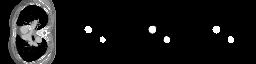

In [ ]:
ID = '41'
to_gif(presentResultsAsGif(ID))